# Table of contents
1. [Data Loading and Data Cleaning](#1.-Data-Loading-and-Data-Cleaning)
2. [Model Based Feature Selection](#2.-Model-Based-Feature-Selection)
3. [Descriptive Analysis](#3.-Descriptive-Analysis)
4. [Data Analysis](#4.-Data-Analysis)
5. [Predicting bankruptcy](#5.-Predicting-bankruptcy)


In [1]:
# runtime
import timeit

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# preprocessing
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

# Ml model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Data Cleaning
In this step we are just going to see if we have any null's and see the shape of the dataset. Descriptive analytics wouldn't make sense since we are going to drop lot's of features in step number 2

In [2]:
bank = pd.read_csv('data.csv')

print(bank.isnull().values.any())
print(bank.shape)

bank

False
(6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


great! let's start dropping features

# 2. Model Based Feature Selection
Model based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. For this case, we are going to use a random forest classifier, since it usually yields good results and because this is a classification task

In [3]:
# training set
X = bank.iloc[:,1:].values
y = bank.iloc[:,0].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# determining optimal number of features
n_features = [5, 10]
for i in n_features:
    # Building the model based feature selection
    select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=i)

    select.fit(X_train, y_train)

    mask = select.get_support()

    X_train_rfe = select.transform(X_train)
    X_test_rfe = select.transform(X_test)

    score = RandomForestClassifier().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
    
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))



Test score: 0.968  number of features: 5
Test score: 0.970  number of features: 10


There's not so much difference between the scores with different features. We are going to work with 10 features since is a 'workable' number of features and has a good a score. Let's run the algorithm again and get the features

In [6]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)

select.fit(X_train, y_train)

mask = select.get_support()

X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = RandomForestClassifier().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)

print("Test score: {:.3f}".format(score), " number of features: {}".format(15))

features = pd.DataFrame({'features':list(bank.iloc[:,1:].keys()), 'select':list(mask)})
features = list(features[features['select']==True]['features'])
features.append('Bankrupt?')

Test score: 0.968  number of features: 15


Let's see the DataFrame we are going to work with it's stats

In [7]:
bank = bank[features]
bank

,Non-industry income and expenditure/revenue,Persistent EPS in the Last Four Seasons,Net Value Growth Rate,Interest Expense Ratio,Total debt/Total net worth,Borrowing dependency,Cash/Total Assets,Net Income to Total Assets,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Bankrupt?
0,0.302646,0.169141,0.000327,0.629951,0.021266,0.390284,0.004094,0.716845,0.827890,0.026601,1
1,0.303556,0.208944,0.000443,0.635172,0.012502,0.376760,0.014948,0.795297,0.839969,0.264577,1
2,0.302035,0.180581,0.000396,0.629631,0.021248,0.379093,0.000991,0.774670,0.836774,0.026555,1
3,0.303350,0.193722,0.000382,0.630228,0.009572,0.379743,0.018851,0.739555,0.834697,0.026697,1
4,0.303475,0.212537,0.000439,0.636055,0.005150,0.375025,0.014161,0.795016,0.839973,0.024752,1
...,...,...,...,...,...,...,...,...,...,...,...
6814,0.303510,0.216602,0.000450,0.631415,0.006655,0.373823,0.099481,0.799927,0.840359,0.027064,0
6815,0.303520,0.216697,0.000445,0.631489,0.004623,0.372505,0.080337,0.799748,0.840306,0.027009,0
6816,0.303512,0.210929,0.000435,0.630612,0.001392,0.369637,0.412885,0.797778,0.840138,0.026791,0
6817,0.303498,0.228326,0.000529,0.630731,0.003816,0.369649,0.112238,0.811808,0.841084,0.026822,0


# 3. Descriptive Analysis

Now that we have a more workable number of features, let's take a look at their stats

## 3.1. Target Variable

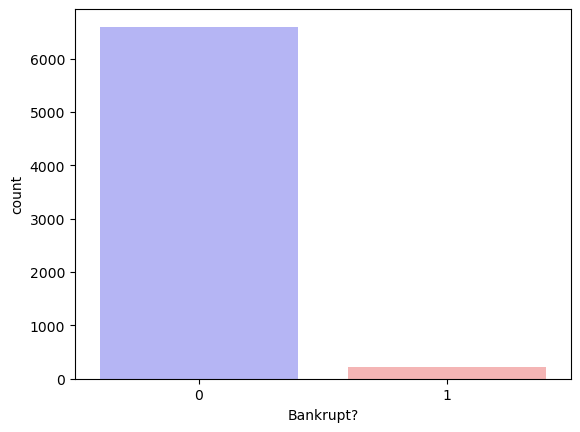

Bankrupt?
0    6599
1     220
dtype: int64

In [8]:
sns.countplot(data=bank, x='Bankrupt?', palette='bwr')
plt.show()

bank.groupby('Bankrupt?').size()

We have highly unbalanced data, this is a problem since the machine learning algorithm could be making prediction based mainly on data majority, that's the reason we got so good reasults in section 2. In this case we are going and try oversampling the data: making synthetic data out of the smaller sample (1)

## 3.2. Features

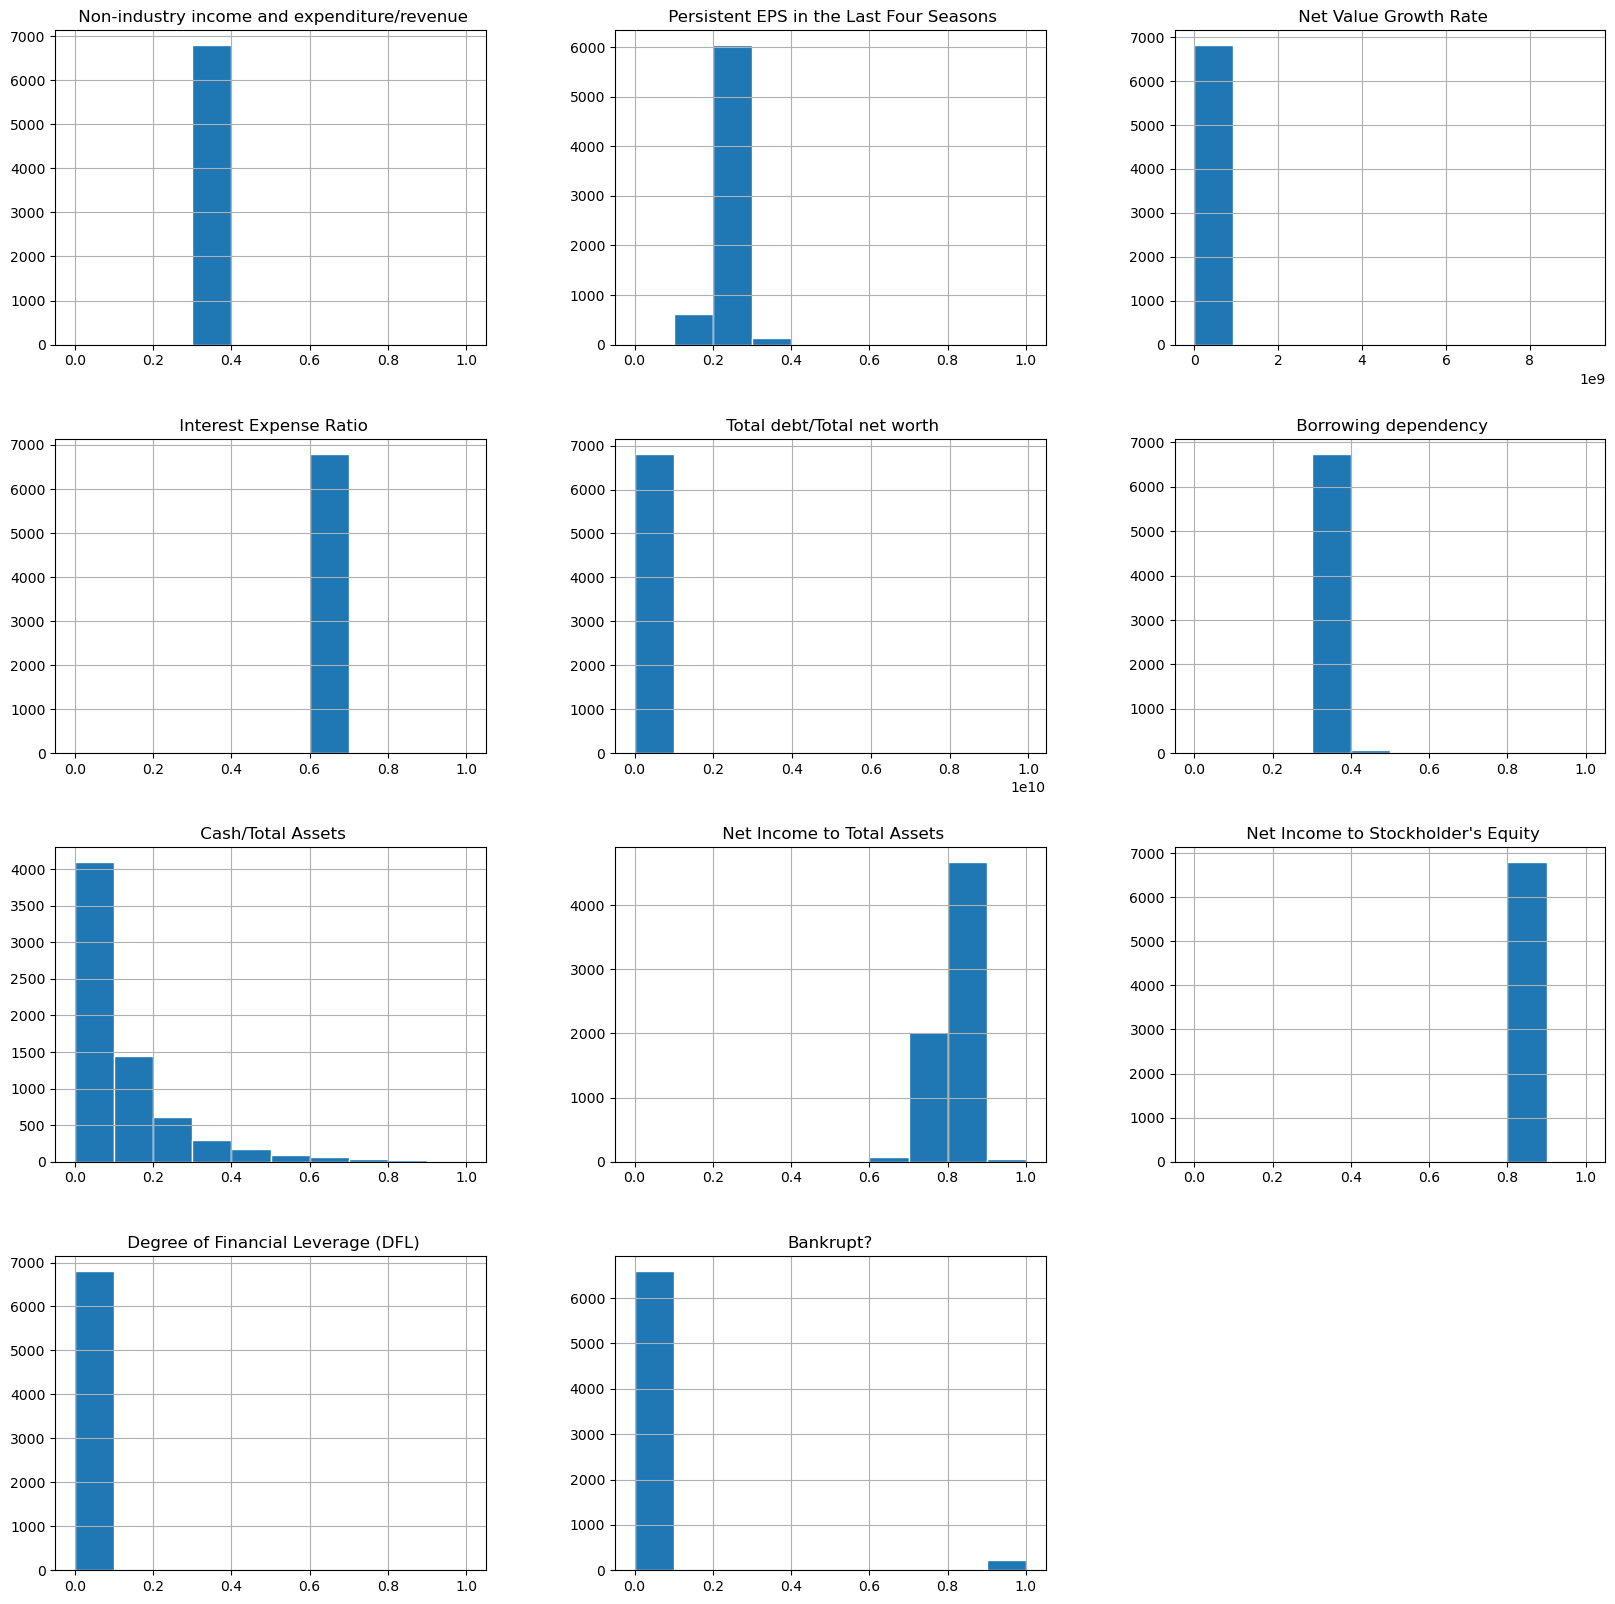

In [9]:
bank.hist(figsize=(20,20), edgecolor='white')
plt.show()

Most of the data is rich on outliers, and in some other the values are located in just one bin. Let's take a closer look at ' Non-industry income and expenditure/revenue'

In [10]:
bins = pd.cut(bank[' Non-industry income and expenditure/revenue'], bins=10)
bins = pd.DataFrame(bins)
bins.value_counts()

 Non-industry income and expenditure/revenue
(0.3, 0.4]                                      6794
(0.2, 0.3]                                        20
(-0.001, 0.1]                                      2
(0.4, 0.5]                                         1
(0.7, 0.8]                                         1
(0.9, 1.0]                                         1
(0.1, 0.2]                                         0
(0.5, 0.6]                                         0
(0.6, 0.7]                                         0
(0.8, 0.9]                                         0
Name: count, dtype: int64

Rows with outliers: 6819
Rows withou outliers: 6631
information lost = 188 rows


<Axes: >

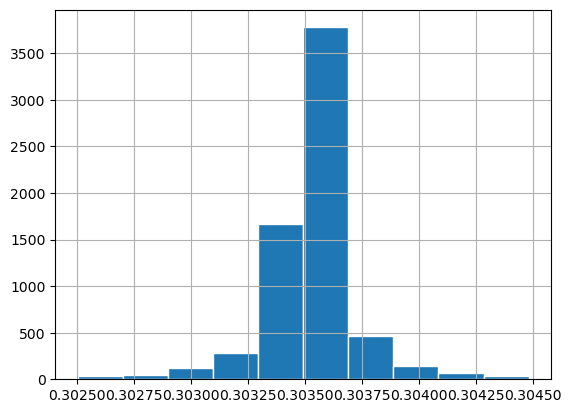

In [11]:
lower = bank[' Non-industry income and expenditure/revenue'] >0.3025
upper = bank[' Non-industry income and expenditure/revenue'] <0.3045

close = bank[lower & upper]
print('Rows with outliers: {}'.format(bank.shape[0]))
print('Rows withou outliers: {}'.format(close.shape[0]))
print('information lost = {} rows'.format(bank.shape[0]-close.shape[0]))
close[' Non-industry income and expenditure/revenue'].hist(edgecolor='white')

The distribution does have a normal distribution but is highly influenced by the outliers. Therefore, when analysing the data, will be better to use the median as our analysis tool for central measures.
Additionally, When we are building our model, we could try and take this outliers out just to see if we can get a better result

In [12]:
display(bank.describe())
bank.shape

,Non-industry income and expenditure/revenue,Persistent EPS in the Last Four Seasons,Net Value Growth Rate,Interest Expense Ratio,Total debt/Total net worth,Borrowing dependency,Cash/Total Assets,Net Income to Total Assets,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Bankrupt?
count,6819.000000,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.303623,0.228813,1.566212e+06,0.630991,4.416337e+06,0.374654,0.124095,0.807760,0.840402,0.027541,0.032263
std,0.011163,0.033263,1.141594e+08,0.011238,1.684069e+08,0.016286,0.139251,0.040332,0.014523,0.015668,0.176710
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.303466,0.214711,4.409689e-04,0.630612,3.007049e-03,0.370168,0.033543,0.796750,0.840115,0.026791,0.000000
50%,0.303525,0.224544,4.619555e-04,0.630698,5.546284e-03,0.372624,0.074887,0.810619,0.841179,0.026808,0.000000
75%,0.303585,0.238820,4.993621e-04,0.631125,9.273293e-03,0.376271,0.161073,0.826455,0.842357,0.026913,0.000000
max,1.000000,1.000000,9.330000e+09,1.000000,9.940000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(6819, 11)

## 3.3. Correlations

<Axes: >

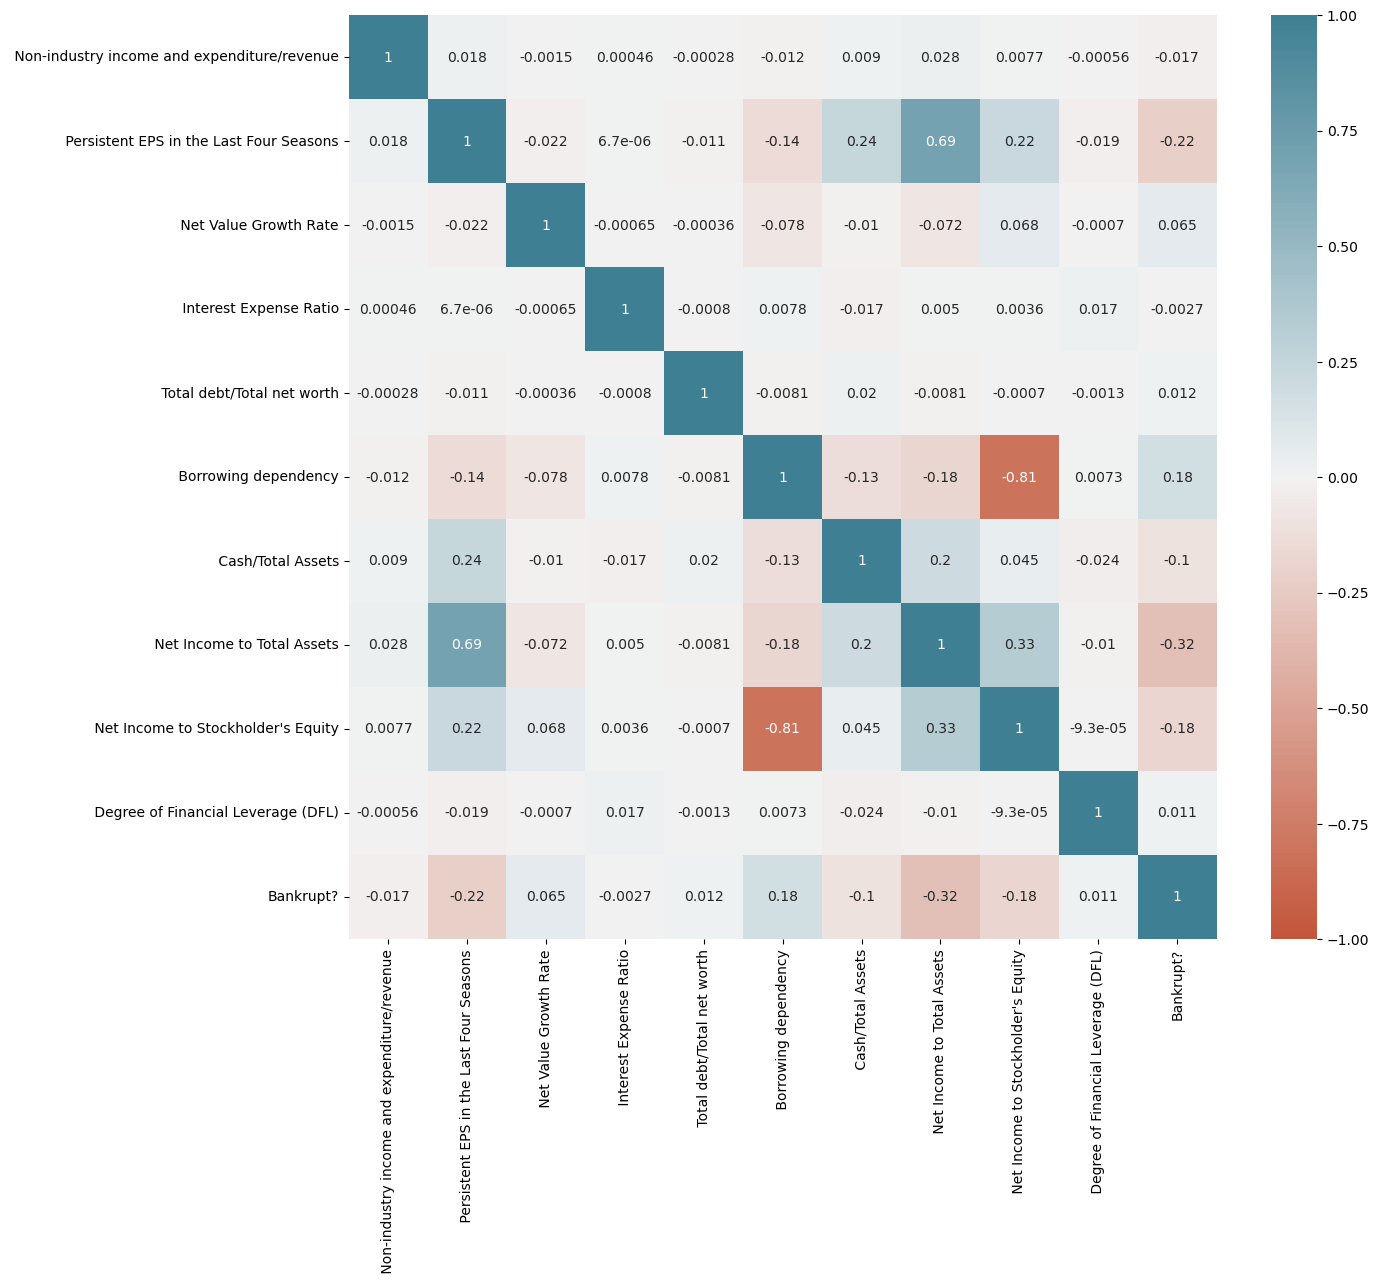

In [13]:
fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(bank.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=True)


We have some interesting correlations. Let's inspect the top 3 and see if we can find any bankruptcy pattern

In [15]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0    Non-industry income and expenditure/revenue  6819 non-null   float64
 1    Persistent EPS in the Last Four Seasons      6819 non-null   float64
 2    Net Value Growth Rate                        6819 non-null   float64
 3    Interest Expense Ratio                       6819 non-null   float64
 4    Total debt/Total net worth                   6819 non-null   float64
 5    Borrowing dependency                         6819 non-null   float64
 6    Cash/Total Assets                            6819 non-null   float64
 7    Net Income to Total Assets                   6819 non-null   float64
 8    Net Income to Stockholder's Equity           6819 non-null   float64
 9    Degree of Financial Leverage (DFL)           6819 non-null   f

We start to see some patterns
- companies with a low 'Net profit before tax/Paid-in capital', 'Persistent EPS in the Last Four Seasons' and 'Net Value Per Share (A)' tend to go bankrupt
- 'Borrowing dependency' has bankrupt companies distributed through all it's range. But, around 0.4, are located the companies that do not go bankrupt. Having around 0.4 doesn't guarantee to be bankrupt safe since there are a lot of companies that went bankrupt with this index, but having a higher o lower index seems to be critical since there aren't any companies operating with this kind of index. Same goes to "Net Income to Stockholder's Equity" but around 0.8

## Descriptive Analysis Conclusions
- We have highly unbalanced data. Therefore, we are going to try applying oversampling
- Most of the features have outliers. Median will be a better analysis method and, also, taking some outliers out will be a good idea when building the model
- companies with a low 'Net profit before tax/Paid-in capital', 'Persistent EPS in the Last Four Seasons' and 'Net Value Per Share (A)' tend to go bankrupt. **A KNN algorithm would yield good results since the clusters are so evident**
- 0.4 'Borrowing dependency' is a good indicator to operate but doesn't completely safe you from bankruptcy
- 0.8 "Net Income to Stockholder's Equity" is a good indicator to operate but doesn't completely safe you from bankruptcy

# 4. Data Analysis
Let's compare the median of bankrupt and not bankrupt companies of each feature to further see if we can find a tendency

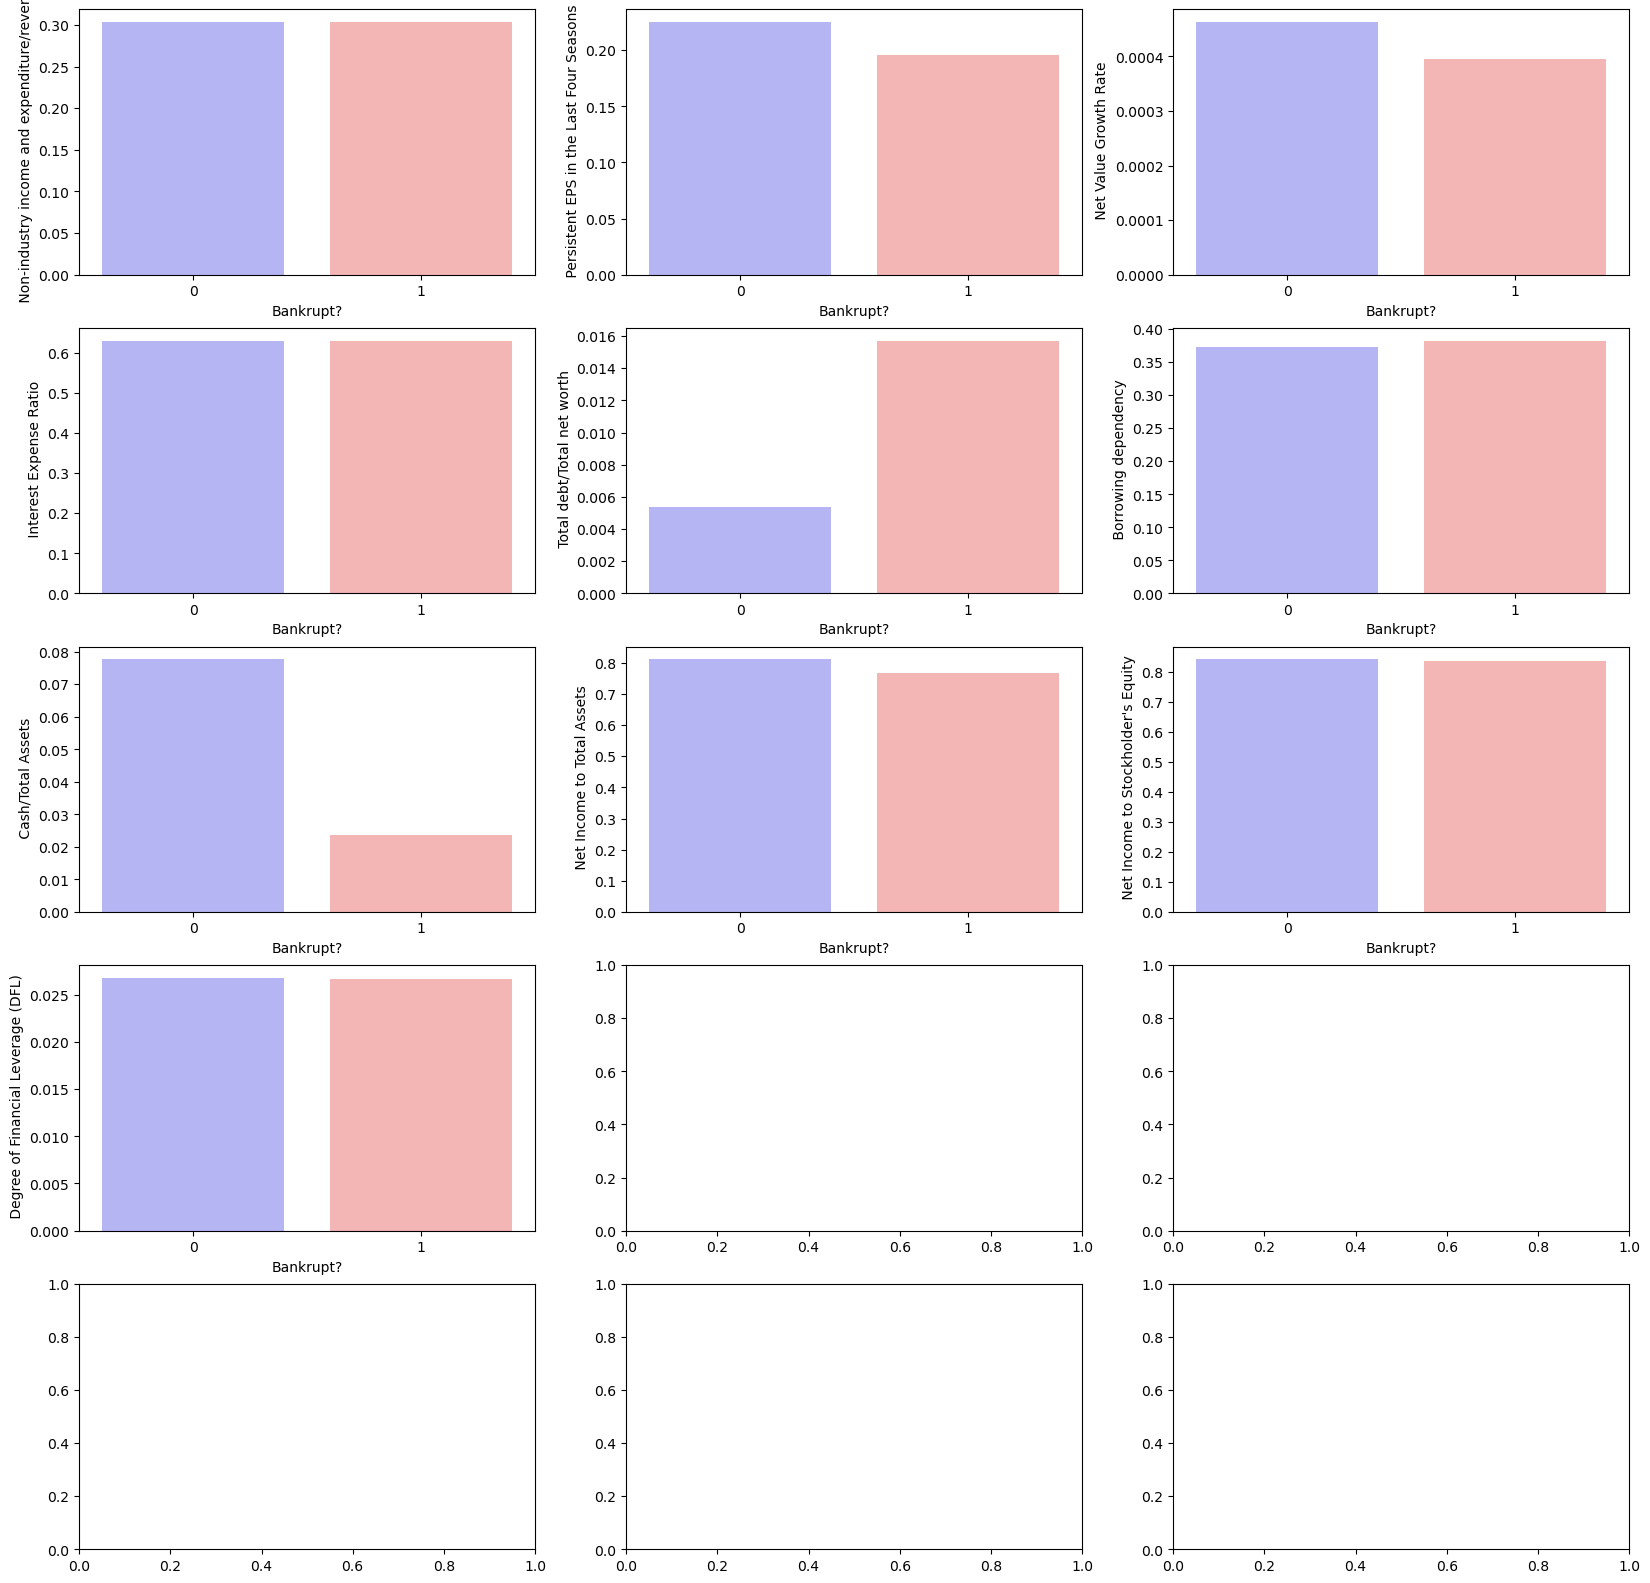

,Bankrupt?,Non-industry income and expenditure/revenue,Persistent EPS in the Last Four Seasons,Net Value Growth Rate,Interest Expense Ratio,Total debt/Total net worth,Borrowing dependency,Cash/Total Assets,Net Income to Total Assets,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL)
0,0,0.303527,0.225111,0.000463,0.630703,0.005377,0.372474,0.077684,0.811492,0.841232,0.026810
1,1,0.303347,0.195944,0.000396,0.630283,0.015723,0.382655,0.023755,0.766297,0.836707,0.026689


In [16]:
central = bank.groupby('Bankrupt?').median().reset_index()
features = list(central.keys()[1:])

fig, ax = plt.subplots(5,3, figsize=(20,20))

ax = ax.ravel()
position = 0

for i in features:
    sns.barplot(data=central, x='Bankrupt?', y=i, ax=ax[position], palette='bwr')
    position += 1
    
plt.show()
display(central)

## Data Analysis Conclusions
Let's mention the most evident tendencies:

Companies with:
- high "Interest-bearing debt interest rate" tend to go bankrupt (≈ 0.000499)
- high "Total debt/Total net worth" tend to go bankrupt (≈ 0.015723)
- high "Fixed Assets Turnover Frequency" tend to go bankrupt (≈ 0.001225)
- low  "Cash/Total Assets" tend to go bankrupt (≈ 0.023755)
- low "Equity to Liability" tend to go bankrupt (≈ 0.018662)

Also, These indicators should be enough to build a reliable model since the trend is very clear. Let's build our model

# 5. Predicting bankruptcy

## 5.1 KNN
A KNN if we recall section 3 and 4 conclusions, an KNN algorithm with features 'Net profit before tax/Paid-in capital', 'Persistent EPS in the Last Four Seasons', "Interest-bearing debt interest rate", "Total debt/Total net worth", "Fixed Assets Turnover Frequency", "Cash/Total Assets" and "Equity to Liability" should do the work. let's go and try. 

In [18]:
start = timeit.default_timer()

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("training set score : {:.2f}".format(knn.score(X_train, y_train)))
print("test set score: {:.2f}".format(knn.score(X_test, y_test)))

stop = timeit.default_timer()
print('Time: ', stop - start)  

training set score : 0.97
test set score: 0.97
Time:  0.5408956999999646
